# Convolutional Neural Network

**Feed-Forward Neural Network(FFNN)** : input으로 $x$를 받아 $y=Wx + b$ 계산하고 이 값에 **activation function** 적용

**Multilayer Perceptron(MLP)** : Layer를 여러 개 쌓아올린 구조

    학습시간, 변수의 개수, 망의 크기(Network size)가 과도하게 커짐

**CNN**의 경우 모든 노드들이 아닌 일부분, 즉 **receptive field**에 각각 **weight**를 적용함

    이미지를 긴 벡터로 바꾸는 MLP와는 달리, CNN은 28*28 행렬을 그대로 이용함
    3*3 커널 윈도우, 즉 행렬로 sweep함으로써 데이터를 다른 형태로 변환함(이 과정이 convolution)
    
    convolution은 주위값들을 반영해서 중앙값을 변화시켜나가는 것 : 목적하는 작업의 성공률이 높도록 이미지를 변형
    이렇게 변형된 이미지를 feature map이라고 함 : 이러한 feature map에 대해 classification을 진행함
    결국, CNN은 원본에 대한 다양한 커널행렬을 통해 다양한 feature map을 생성하고 여기에 대해 학습을 진행함

**용어들**

+ width   : 이미지의 가로, 세로 픽셀사이즈
+ channel : 흑백일 경우 1, RGB일 경우 3
+ 기본적 데이터 형태 : [이미지 수, width, width, channel]
+ hidden : fully connected layer의 hidden neuron 개수
+ pooling : '골라내기', 즉 사이즈를 줄이는 과정
+ conv-ReLu-pooling

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

/Users/hyunwoogu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### parameters

In [2]:
labels = 10
width = 28
channels = 1
valid = 10000

steps = 1000
batch = 100  # stochastic gradient descent batch size
patch = 5    # convolutional kernel size
depth = 8    # convolutional kernel depth size = # of convolutional kernels
hidden= 100  # of hidden neurons in the fully connected layer

alpha = .001 # learning rate

### data preprocessing

In [3]:
Data   = pd.read_csv('train.csv')    # 42000 * 785

Labels = np.array(Data.pop('label')) # popping out the label column
Labels = LabelEncoder().fit_transform(Labels)[:, None]
Labels = OneHotEncoder().fit_transform(Labels).todense()

Data = StandardScaler().fit_transform(np.float32(Data.values)) # dataframe into numpy array
Data = Data.reshape(-1, width, width, channels) # data into 2d images

TrainData,   ValidData = Data[:-valid], Data[-valid:]
TrainLabels, ValidLabels = Labels[:-valid], Labels[-valid:]

### data structure

In [4]:
print('train data shape = ' + str(TrainData.shape) + ' = (TRAIN, WIDTH, WIDTH, CHANNELS)')
print('labels shape = ' + str(Labels.shape) + ' = (TRAIN, LABELS)')

train data shape = (32000, 28, 28, 1) = (TRAIN, WIDTH, WIDTH, CHANNELS)
labels shape = (42000, 10) = (TRAIN, LABELS)


### Model

In [5]:
tfData = tf.placeholder(tf.float32, shape=(None, width, width, channels))
tfLabels = tf.placeholder(tf.float32, shape=(None, labels))

In [6]:
w1 = tf.Variable(tf.truncated_normal([patch, patch, channels, depth], stddev=0.1))
b1 = tf.Variable(tf.zeros([depth]))
w2 = tf.Variable(tf.truncated_normal([patch, patch, depth, 2*depth], stddev=0.1))
b2 = tf.Variable(tf.constant(1.0, shape=[2*depth]))
w3 = tf.Variable(tf.truncated_normal([width // 4 * width // 4 * 2*depth, hidden], stddev=0.1))
b3 = tf.Variable(tf.constant(1.0, shape=[hidden]))
w4 = tf.Variable(tf.truncated_normal([hidden, labels], stddev=0.1))
b4 = tf.Variable(tf.constant(1.0, shape=[labels]))

### Layers

In [7]:
def logits(data):
    # Convolutional layer 1
    x = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b1)
    # Convolutional layer 2
    x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b2)
    # Fully connected layer
    x = tf.reshape(x, (-1, width // 4 * width // 4 * 2*depth))
    x = tf.nn.relu(tf.matmul(x, w3) + b3)
    return tf.matmul(x, w4) + b4

### Prediction

In [8]:
tfPred = tf.nn.softmax(logits(tfData))

### Loss function

In [9]:
tfLoss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits(tfData), labels=tfLabels))
tfAcc = 100*tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(tfPred, 1), tf.argmax(tfLabels, 1))))
tfOpt = tf.train.RMSPropOptimizer(alpha)
tfStep = tfOpt.minimize(tfLoss)

### Train

In [10]:
init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)

In [11]:
ss = ShuffleSplit(n_splits=steps, train_size=batch)
ss.get_n_splits(TrainData, TrainLabels)

history = [(0, np.nan, 10)]

for step, (idx, _) in enumerate(ss.split(TrainData,TrainLabels), start=1):
    fd = {tfData:TrainData[idx], tfLabels:TrainLabels[idx]}
    session.run(tfStep, feed_dict=fd)
    if step%500 == 0:
        fd = {tfData:ValidData, tfLabels:ValidLabels}
        validLoss, validAccuracy = session.run([tfLoss, tfAcc], feed_dict=fd)
        history.append((step, validLoss, validAccuracy))
        print('Step %i \t Valid. Acc. = %f'%(step, validAccuracy), end='\n')

/Users/hyunwoogu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1639: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Step 500 	 Valid. Acc. = 96.639999
Step 1000 	 Valid. Acc. = 97.320000


### Test

In [15]:
Test = pd.read_csv('test.csv') 

In [24]:
TestData = StandardScaler().fit_transform(np.float32(Test.values)) # Convert the dataframe to a numpy array
TestData = TestData.reshape(-1, width, width, channels) # Reshape the data into 42000 2d images

In [25]:
TestPred = session.run(tfPred, feed_dict={tfData:TestData})
TestLabels = np.argmax(TestPred, axis=1)

### Plot

Label Prediction: 5


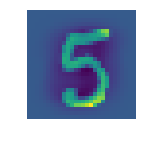

In [31]:
k = 10
print("Label Prediction: %i"%TestLabels[10])

fig = plt.figure(figsize=(2,2))
plt.axis('off')

plt.imshow(TestData[k,:,:,0])
plt.show()